

# Extracting Latent Features

## Importing pakages 

In [1]:
#Packages for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
from datetime import datetime
from scipy import stats
from scipy.sparse import csc_matrix

#Packages for splitting data
from sklearn import base
from sklearn.model_selection import KFold

#Packages for controlling figure size
from IPython.core.pylabtools import figsize


In [2]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

## Importing Clean Data from the CSV file 

In [3]:
#Setting the file path
train_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\train_cleaned.csv'
test_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\test_cleaned.csv'

#Reading the csv file to pandas dataframe
train_clean = pd.read_csv(train_file)
test_clean = pd.read_csv(test_file)

## Checking the Data. 
Number of columns, whether it was imported correctly, number of missing values etc.

In [4]:
#Check shape of the dataset and number of columns
print("Train Shape", train_clean.shape)
print("Test Shape", test_clean.shape)

Train Shape (7377418, 37)
Test Shape (2556790, 37)


In [5]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 37 columns):
msno                        object
song_id                     object
source_system_tab           object
source_screen_name          object
source_type                 object
target                      int64
song_length                 float64
genre_ids                   object
artist_name                 object
composer                    object
lyricist                    object
language                    float64
city                        int64
bd                          int64
gender                      object
registered_via              int64
lyricist_count              int64
artist_count                int64
composer_count              int64
genre_count                 int64
isrc_country                object
isrc_year                   int64
song_freq                   float64
artist_freq                 float64
composer_artist_lyricist    int64
composer_artist   

## Target Encoding

### Features with more than 25 categories will be target encoded. Rest will one-hot encoding

In [6]:
# Defining class to target encoding of training data
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,smoothing=5,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        self.smoothing = smoothing

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        
        
        # Spliting the data into kfolds
        kf = KFold(n_splits = self.n_fold)

        # Naming the column
        col_mean_name = self.colnames + '_' + 'encoded'
        X[col_mean_name] = np.nan

        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            #print(tr_ind,val_ind) 
            
            # creating target values
            enc = X_tr.groupby(self.colnames)[self.targetName].agg(['count', 'mean'])
            counts = enc['count']
            means = enc['mean']
            
            # Applying smoothing to counter low frequency samples
            smooth = (counts * means + self.smoothing * mean_of_target) / (counts + self.smoothing)

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(smooth)

            # If variable not found then fill with global mean
            X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        # Droping the original column
        if self.discardOriginal_col:
            X = X.drop(self.colnames, axis=1)
            

        return X

In [7]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName,verbosity=True):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        self.verbosity = verbosity
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):


        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index()
        global_mean = mean[self.encodedName].mean()
        mean[self.encodedName].fillna(global_mean,inplace=True)
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        
        X[self.encodedName] = X[self.colNames].map(dd)
        X[self.encodedName].fillna(global_mean, inplace = True)
        #X = X.replace({self.encodedName: dd})
        
        if self.verbosity:
            print('Done:',(self.colNames))

        return X

In [8]:
# Encoding Training Data
target_encod_col = ['genre_ids', 'composer', 'artist_name', 'lyricist', 'isrc_country']
train_enc = train_clean
for col in target_encod_col:
    targetc = KFoldTargetEncoderTrain(col,'target',n_fold=5, discardOriginal_col=False )
    train_enc = targetc.fit_transform(train_enc)

Correlation between the new feature, genre_ids_encoded and, target is -0.02021206771320489.
Correlation between the new feature, composer_encoded and, target is 0.10282564772309626.
Correlation between the new feature, artist_name_encoded and, target is 0.10598778158865219.
Correlation between the new feature, lyricist_encoded and, target is 0.07321287042731096.


MemoryError: 

In [ ]:
# Encoding Testing Data
test_enc = test_clean
encoded_name = ['genre_ids_encoded', 'composer_encoded', 'artist_name_encoded', 'lyricist_encoded', 'isrc_country_encoded']
for col in target_encod_col:
    targetc = KFoldTargetEncoderTest(train_enc,col,col+'_encoded' )
    test_enc = targetc.fit_transform(test_enc)
    
#train_enc = train_enc.drop(target_encod_col,axis=1)

#### Resizing the data for efficient use of memory¶

In [ ]:
# Memory used before resize
mem_train = train_enc.memory_usage(index=True).sum()
mem_test = test_enc.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem_train/ 1024**2))
print("Memory consumed by training set  :   {} MB" .format(mem_test/ 1024**2))

In [ ]:
def reduce_size(train, istrain = True):
    drop_col = ['registration_day', 'expiration_day', 
                'registration_month', 'composer_artist_lyricist', 'composer_artist', 'gender']
    train = train.drop(drop_col,axis=1)

    # Selecting string columns
    cat_names = list(train.select_dtypes(include='object').columns)

    #Converting to categories
    train[cat_names] = train[cat_names].astype('category')

    int_names = list(train.select_dtypes(include='int64').columns)
    int_names.remove('count_artist_played')
    int_names.remove('count_song_played')
    if (istrain == False):
        int_names = int_names[1:]
    train[int_names] = train[int_names].astype('int16')
    train[['count_artist_played', 'count_song_played']] = train[['count_artist_played', 'count_song_played']].astype('int32')
    
    if istrain:
        int_8_col = ['target']
        train[int_8_col] = train[int_8_col].astype('int8')


    float_names = list(train.select_dtypes(include='float64').columns)
    if (istrain == False):
        float_names = float_names + ['genre_ids_encoded', 'composer_encoded', 'artist_name_encoded', 'lyricist_encoded', 'isrc_country_encoded']
    
    float_names.remove('song_length')
    train[float_names] = train[float_names].astype('float16')
    train['song_length'] = train['song_length'].astype('float32')
    
    return train

train_enc = reduce_size(train_enc)
test_enc = reduce_size(test_enc, istrain = False)

In [ ]:
# Memory usage post resizing 
mem_train = train_enc.memory_usage(index=True).sum()
mem_test = test_enc.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem_train/ 1024**2))
print("Memory consumed by testing set  :   {} MB" .format(mem_test/ 1024**2))

In [ ]:
numeric = list(test_enc.select_dtypes(exclude='category').columns)
test_enc[numeric].max()

In [ ]:
test_enc.head()

## Using SVD Decomposition to extract User-Song Features

In [ ]:
# Function to replace new users_songs with global average.

def cold_start(train_data, test_data, feature_data):
    
    # Global Average
    global_avg = list(feature_data.mean(axis=0))
    
    # Merging the new features
    test_data = test_data.merge(feature_data, how = 'left', on = 'msno')
    
    
    # Finding users that are present in test data and absent in train data
    diff = list(set(test_data.msno) - set(train_data.msno))
    diff_index = test_data[test_data.msno.isin(diff)].index
    
    # Feature Column Names
    cols = list(feature_data.columns)
    cols.remove('msno')
    
    # Replacing the missing user values with global average
    test_data.loc[diff_index, cols] = global_avg + 2
    
    return test_data

In [ ]:
# Creating matrix of user id and song _id with target as values
matrix = train_enc.drop(train_enc.columns.difference(['msno','song_id','target']),axis = 1)

# Unique songs and users
n_users = matrix.msno.unique().shape[0]
n_songs = matrix.song_id.unique().shape[0]

# Converting msno and song ids to numeric labels
users = pd.DataFrame(matrix.msno.unique(), columns = ['msno'])
users['index'] = users.index
users.set_index('msno', inplace = True)
users = users.to_dict()['index']
matrix['msno_index'] =  matrix.msno.map(users)

songs = pd.DataFrame(matrix.song_id.unique(), columns = ['song'])
songs['index'] = songs.index
songs.set_index('song', inplace = True)
songs = songs.to_dict()['index']
matrix['song_index'] =  matrix.song_id.map(songs)

# Dropping the actual msno and song ids
matrix= matrix.drop(['msno', 'song_id'], axis = 1)
matrix.head()

In [ ]:
# Import SVD Library
from sklearn.decomposition import TruncatedSVD

# creating memory efficient column sparse matrix for use in svd decomposition
user_song = csc_matrix((matrix.target, (matrix.msno_index, matrix.song_index)),(n_users,n_songs))

# Initialize and fit SVD on user-song matrix
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
svd.fit(user_song)

In [ ]:
# Total explained variation
print("Total Explained Variation:", svd.explained_variance_ratio_.sum())

# Plotting the explained varaiation against the number of components
_ = plt.plot(svd.singular_values_)

#print(svd.singular_values_)

In [19]:
# Extracting the components into data frame
user_song_reduced = svd.transform(user_song)
col_name = ['us_'+str(i) for i in range(1,21)]
user_song_feat = pd.DataFrame(user_song_reduced, columns = col_name)
user_song_feat['msno'] = train_enc.msno.unique()

# maping the components into the training data set
train_enc = train_enc.merge(user_song_feat, how = 'left', on = 'msno')
#train_clean = train_clean.merge(user_song_feat, how = 'left', on = 'msno')

In [20]:
# Maping components into testing data set
test_enc = cold_start(train_enc,test_enc,user_song_feat)

In [21]:
test_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 56 columns):
id                      int64
msno                    object
song_id                 category
source_system_tab       category
source_screen_name      category
source_type             category
song_length             float32
genre_ids               category
artist_name             category
composer                category
lyricist                category
language                float16
city                    int16
bd                      int16
registered_via          int16
lyricist_count          int16
artist_count            int16
composer_count          int16
genre_count             int16
isrc_country            category
isrc_year               int16
song_freq               float16
artist_freq             float16
count_song_played       int32
count_artist_played     int32
duration                float16
registration_year       int16
expiration_year         int16
expiratio

In [22]:
def extra_reduce_size(data):
    float_names = list(data.select_dtypes(include='float64').columns)
    data[float_names] = data[float_names].astype('float16')
    data['duration'] = data['duration'].astype('int32')

    float_to_inc = ['song_freq', 'artist_freq', 'language']
    data[float_to_inc] = data[float_to_inc].astype('int16')

    #train_enc.drop('msno', axis = 1, inplace = True)
    return data

train_enc = extra_reduce_size(train_enc)
test_enc = extra_reduce_size(test_enc)


In [23]:
#numeric = list(train_enc.select_dtypes(exclude='category').columns)
#train_enc[numeric].min()

## SVD Implementation of User-genre_id Features

In [24]:
# Creating user-genre sparse matrix
matrix = train_clean.drop(train_clean.columns.difference(['msno','genre_ids','target']),axis = 1)
matrix = pd.pivot_table(train_clean,values = 'target', index = 'msno', columns = 'genre_ids', aggfunc= np.sum).fillna(0)
user_genre = csc_matrix(matrix)


0.9679396048126867


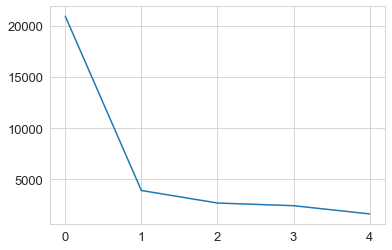

In [25]:
# Initialize and fit SVD on user-song matrix
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(user_genre)

# Total explained variation
print(svd.explained_variance_ratio_.sum())

# Plotting the explained varaiation against the number of components
plt.plot(svd.singular_values_)

In [26]:
# Extracting the components into data frame
user_genre_reduced = svd.transform(user_genre)
col_name = ['ug_'+str(i) for i in range(1,6)]
user_genre_feat = pd.DataFrame(user_genre_reduced, columns = col_name)
user_genre_feat['msno'] = matrix.index

# maping the components into the training data set
train_enc = train_enc.merge(user_genre_feat, how = 'left', on = 'msno')

# maping the components into the test data set
test_enc = cold_start(train_enc,test_enc,user_genre_feat)

#train = train.merge(user_genre_feat, how = 'left', on = 'msno')
#train_enc.info()



## SVD Implementation of User-artist name Features

In [27]:
# Creating user-artist sparse matrix
matrix = train_clean.drop(train_clean.columns.difference(['msno','artist_name','target']),axis = 1)
matrix = matrix.groupby(['msno', 'artist_name'])['target'].sum()
matrix = matrix.reset_index()

# Unique songs and artist
n_users = matrix.msno.unique().shape[0]
n_artist = matrix.artist_name.unique().shape[0]

# Converting msno and artist to numeric labels
users = pd.DataFrame(matrix.msno.unique(), columns = ['msno'])
users['index'] = users.index
users.set_index('msno', inplace = True)
users = users.to_dict()['index']
matrix['msno_index'] =  matrix.msno.map(users)

artist = pd.DataFrame(matrix.artist_name.unique(), columns = ['artist'])
artist['index'] = artist.index
artist.set_index('artist', inplace = True)
artist = artist.to_dict()['index']
matrix['artist_index'] =  matrix.artist_name.map(artist)

# Dropping the actual msno and artist
user_index = matrix.msno.unique()
matrix= matrix.drop(['msno', 'artist_name'], axis = 1)
matrix.head()

#user_genre = csc_matrix(matrix)
#matrix.head()

,target,msno_index,artist_index
0,2,0,0
1,1,0,1
2,0,0,2
3,3,0,3
4,4,0,4


0.45846842453414877


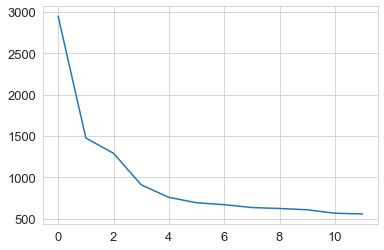

In [28]:
# Creating user-genre sparse matrix
user_artist = csc_matrix((matrix.target, (matrix.msno_index, matrix.artist_index)),(n_users,n_artist))

# Initialize and fit SVD on user-song matrix
svd = TruncatedSVD(n_components=12, n_iter=7, random_state=42)
svd.fit(user_artist)

# Total explained variation
print(svd.explained_variance_ratio_.sum())

# Plotting the explained varaiation against the number of components
plt.plot(svd.singular_values_)

In [29]:
# Extracting the components into data frame
user_artist_reduced = svd.transform(user_artist)
col_name = ['ua_'+str(i) for i in range(1,13)]
user_artist_feat = pd.DataFrame(user_artist_reduced, columns = col_name)
user_artist_feat['msno'] = user_index
#train_enc.any()

# maping the components into the training data set
train_enc = train_enc.merge(user_artist_feat, how = 'left', on = 'msno')

# maping the components into the testing data set
test_enc = cold_start(train_enc,test_enc,user_artist_feat)


#train = train.merge(user_artist_feat, how = 'left', on = 'msno')
#train_enc.info()

In [30]:
float_names = list(train_enc.select_dtypes(include='float64').columns)
train_enc[float_names] = train_enc[float_names].astype('float16')
test_enc[float_names] = test_enc[float_names].astype('float16')

In [31]:
# Memory usage post resizing 
mem_train = train_enc.memory_usage(index=True).sum()
mem_test = test_enc.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem_train/ 1024**2))
print("Memory consumed by testing set  :   {} MB" .format(mem_test/ 1024**2))

Memory consumed by training set  :   1214.987590789795 MB
Memory consumed by testing set  :   518.7513332366943 MB


In [32]:
train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 73 columns):
msno                    object
song_id                 category
source_system_tab       category
source_screen_name      category
source_type             category
target                  int8
song_length             float32
genre_ids               category
artist_name             category
composer                category
lyricist                category
language                int16
city                    int16
bd                      int16
registered_via          int16
lyricist_count          int16
artist_count            int16
composer_count          int16
genre_count             int16
isrc_country            category
isrc_year               int16
song_freq               int16
artist_freq             int16
count_song_played       int32
count_artist_played     int32
duration                int32
registration_year       int16
expiration_year         int16
expiration_month  

### Exporting the files for Final Modeling

In [33]:
train_enc.to_csv('D:\\Abhishek\\Personal\\Springboard\\music_recom\\train_final.csv',index = False)
test_enc.to_csv('D:\\Abhishek\\Personal\\Springboard\\music_recom\\test_final.csv',index = False)